In [2]:
# Lets start by converting book, rating users into the appropriate rows and cols.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load the data

books_df = pd.read_csv("../data/Books.csv")
users_df = pd.read_csv("../data/Users.csv")
ratings_df = pd.read_csv("../data/ratings.csv")

books_df.head()

C:\Users\wangn\AppData\Local\Temp\ipykernel_71944\209608937.py:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv("../data/Books.csv")


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [3]:
books_df.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [4]:
# Convert as folllowing standarized format:

"""

products:

| name           | type | description                               |
| -------------- | ---- | ----------------------------------------- |
| id             | str  | Unique identifier of the product          |
| product_title  | str  | Title of the product                      |
| product_image  | str  | Image of the product                      |
| product_price  | int  | Price of the product (if available)  |
| product_soup   | str  | All Aggregated Description of the product |
| product_tags   | str  | List of tags of the product, sep by comma |

From:

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],

"""

products_books = books_df.copy()
products_books['id'] = products_books["ISBN"]
products_books["product_title"] = products_books["Book-Title"]
products_books["product_image"] = products_books["Image-URL-M"]
products_books["product_price"] = np.nan
products_books["product_soup"] = products_books["Book-Title"] + " " + products_books["Book-Author"] + " " + products_books["Publisher"]
products_books["product_tags"] = np.nan


products_books = products_books[["id", "product_title", "product_image", "product_price", "product_soup", "product_tags"]]
products_books.head()

,id,product_title,product_image,product_price,product_soup,product_tags
0,0195153448,Classical Mythology,http://images.amazon.com/images/P/0195153448.0...,NaN,Classical Mythology Mark P. O. Morford Oxford ...,NaN
1,0002005018,Clara Callan,http://images.amazon.com/images/P/0002005018.0...,NaN,Clara Callan Richard Bruce Wright HarperFlamin...,NaN
2,0060973129,Decision in Normandy,http://images.amazon.com/images/P/0060973129.0...,NaN,Decision in Normandy Carlo D'Este HarperPerennial,NaN
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,http://images.amazon.com/images/P/0374157065.0...,NaN,Flu: The Story of the Great Influenza Pandemic...,NaN
4,0393045218,The Mummies of Urumchi,http://images.amazon.com/images/P/0393045218.0...,NaN,The Mummies of Urumchi E. J. W. Barber W. W. N...,NaN


In [5]:
ratings_df.columns

Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

In [6]:
# Convert Transactions as standarized format

import uuid
"""
To: 
| name       | type | description                          |
| ---------- | ---- | ------------------------------------ |
| id         | str  | Unique identifier of the transaction |
| user_id    | str  | Unique identifier of the user        |
| product_id | str  | Unique identifier of the product     |
| rate       | int  | Positive association rating          |

From: ratings_df.columns
Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

"""

transactions_books = ratings_df.copy()

# random_id = np.random.randint(0, 100000, len(transactions_books))
transactions_books["id"] = uuid.uuid4()
transactions_books["user_id"] = transactions_books["User-ID"]
transactions_books["product_id"] = transactions_books["ISBN"]
transactions_books["rate"] = transactions_books["Book-Rating"]//2

transactions_books = transactions_books[["id", "user_id", "product_id", "rate"]]

transactions_books.head()

,id,user_id,product_id,rate
0,05345165-490c-4d1e-840f-2a212b277d93,276725,034545104X,0
1,05345165-490c-4d1e-840f-2a212b277d93,276726,0155061224,2
2,05345165-490c-4d1e-840f-2a212b277d93,276727,0446520802,0
3,05345165-490c-4d1e-840f-2a212b277d93,276729,052165615X,1
4,05345165-490c-4d1e-840f-2a212b277d93,276729,0521795028,3


In [7]:

# remove products where under x interactions in total.

def remove_under_interactions(df, col_name, threshhold=10):
    # Find id of products where total aggregated mentions in transactiosn is less than 50.
    counts = df[col_name].value_counts()
    df = df[df[col_name].isin(counts[counts > threshhold].index)]
    return df




In [8]:
print(len(transactions_books))
print('unique products:', len(transactions_books["product_id"].unique()))
print('unique users:', len(transactions_books["user_id"].unique()))

transactions = transactions_books

1149780
unique products: 340556
unique users: 105283


In [13]:
# Lets keep it at 30 as a treshhold.

def clean_with_treshhold(user_treshhold, product_treshold, original_transactions, products, save_as_append="", verbose=False):
    """
    Iteratively removes transactions until user and product transactions meet the criteria.
    """

    prev_transaction_count = -1
    transactions = original_transactions
    
    if verbose:
        print('Start count of transactions', len(original_transactions))
        print("Unique books: ", len(transactions["product_id"].unique()))
        print("Unique users: ", len(transactions["user_id"].unique()))

    while(prev_transaction_count != len(transactions)):
        transactions = remove_under_interactions(transactions, "product_id", product_treshold)
        transactions = remove_under_interactions(transactions, "user_id", user_treshhold)
        prev_transaction_count = len(transactions)

    if verbose:
        print('final count of transactions', len(transactions) )
        print("Unique books: ", len(transactions["product_id"].unique()))
        print("Unique users: ", len(transactions["user_id"].unique()))
    
    # Products
    products = products[products["id"].isin(transactions["product_id"].unique())]
    
    
    # Save.
    if save_as_append != "":
        # sort products by times they appear at transactions
        # Count the times each product appears in transactions
        product_counts = transactions["product_id"].value_counts()

        # Create a new dataframe with products sorted by count
        sorted_products = product_counts.reset_index()
        sorted_products.columns = ['product_id', 'count']
        # print('sorted_products', sorted_products.columns)
        # print('products_Data', products.columns)
        # Merge this with the original products dataframe to keep the order
        products_books = pd.merge(sorted_products, products, left_on='product_id', right_on='id')
        products_books.to_csv(f"../data/products{save_as_append}.csv", index=False)

        transactions_books = transactions[transactions["product_id"].isin(products_books["id"])]
        transactions_books.to_csv(f"../data/transactions{save_as_append}.csv", index=False)
    
    
    return transactions



1 365514
2 514048
3 605926
4 672043
5 723547
6 765103
7 799291
8 827127
9 851282


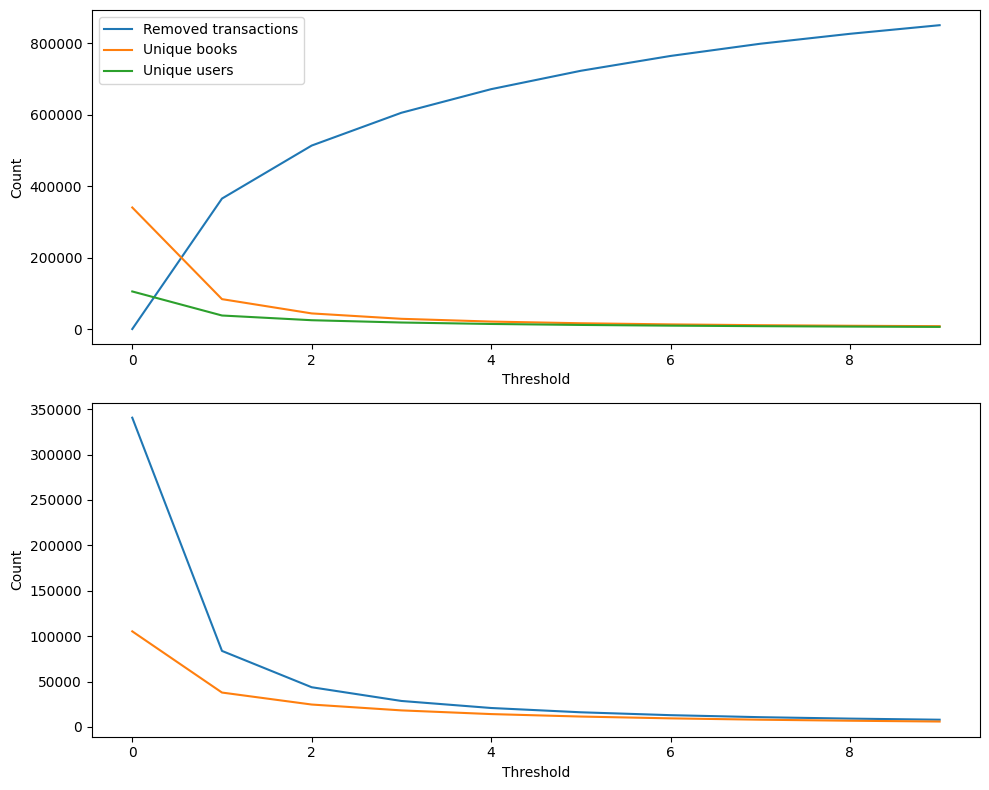

In [23]:
# Chart how many books are removed if treshhold increases from 20 - 200 by 10

import matplotlib.pyplot as plt

removed_transactions = [0]
unique_books = [len(transactions_books["product_id"].unique())]
unique_products = [len(transactions_books["user_id"].unique())]
for i in range(1, 10, 1):
    # user_treshhold, product_treshold, original_transactions, products, save_as_append=""):
    transactions = clean_with_treshhold(i, i*2, transactions_books, products_books)
    print(i, len(transactions_books) - len(transactions)) 
    removed_transactions.append(len(transactions_books) - len(transactions))
    unique_books.append(len(transactions["product_id"].unique()))
    unique_products.append(len(transactions["user_id"].unique()))


# Create subplots with 2 rows and 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the removed transactions, unique books, and unique users on the first subplot
ax1.plot(removed_transactions)
ax1.plot(unique_books)
ax1.plot(unique_products)

# Plot a closer look at unique books and unique users on the second subplot
ax2.plot(unique_books)
ax2.plot(unique_products)

# Set labels and legend
ax1.legend(["Removed transactions", "Unique books", "Unique users"])
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Count")

ax2.set_xlabel("Threshold")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [9]:
transactions = clean_with_treshhold(4, 10, transactions_books, products_books, save_as_append="_books_v1", verbose=True)

Start count of transactions 1149780
Unique books:  340556
Unique users:  105283
final count of transactions 390021
Unique books:  16145
Unique users:  6657
